In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_ref_df(filename):
    ref_df = pd.read_csv(filename).sort_values("score",ascending=False)
    top_100_names = set(ref_df.head(100).name.values)
    top_1000_names = set(ref_df.head(1000).name.values)
    return top_100_names, top_1000_names

def read_logfile(filename):
    with open(filename) as ifs:
        lines = ifs.readlines()
        return int(lines[-2].split()[3])

def count_hits(df_in,top_100, top_1000):
    hit_count = 1
    hit_list = []
    for idx,name in enumerate(df_in.Name.values):
        if name in top_1000:
            hit_list.append([idx,hit_count])
            hit_count += 1
    df_in.sort_values("score",ascending=False,inplace=True)
    num_hits_100 = len(df_in.query("Name in @top_100"))
    num_hits_1000 = len(df_in.query("Name in @top_1000"))
    return num_hits_100, num_hits_1000, hit_list

In [3]:
ref_dict = {}
for dirname in ["docking","rocs"]:
    for libname in ["amide","quinazoline"]:
        ref_dict[f"{libname}_{dirname}"] = read_ref_df(f"{dirname}/{libname}_{dirname}_scores.csv")            

In [4]:
ref_dict.keys()

dict_keys(['amide_docking', 'quinazoline_docking', 'amide_rocs', 'quinazoline_rocs'])

In [5]:
res = []
plot_list = []
for k in ref_dict.keys():
    lib_name, dirname = k.split("_")
    for method in ["ts","rws"]:
        hit_filename = f"{dirname}/{method}_{lib_name}_{dirname}_logs.csv"
        hit_df = pd.read_csv(hit_filename)
        num_evaluations = read_logfile(f"{dirname}/{method}_{lib_name}_{dirname}_logs.txt")
        count_top_100, count_top_1000, hit_order = count_hits(hit_df,*ref_dict[k])
        res.append([method,lib_name, dirname, count_top_100, count_top_1000, num_evaluations,hit_order])
        plot_list.append([lib_name,dirname,method,hit_order])
res_df = pd.DataFrame(res,columns=["method","dataset","task","top100","top1000","evaluations","hit_order"])
res_df[res_df.columns[:-1]]

,method,dataset,task,top100,top1000,evaluations
0,ts,amide,docking,62,546,20000
1,rws,amide,docking,32,356,20480
2,ts,quinazoline,docking,44,363,11500
3,rws,quinazoline,docking,33,260,10279
4,ts,amide,rocs,79,495,11000
5,rws,amide,rocs,96,868,11612
6,ts,quinazoline,rocs,100,999,11500
7,rws,quinazoline,rocs,96,804,10079


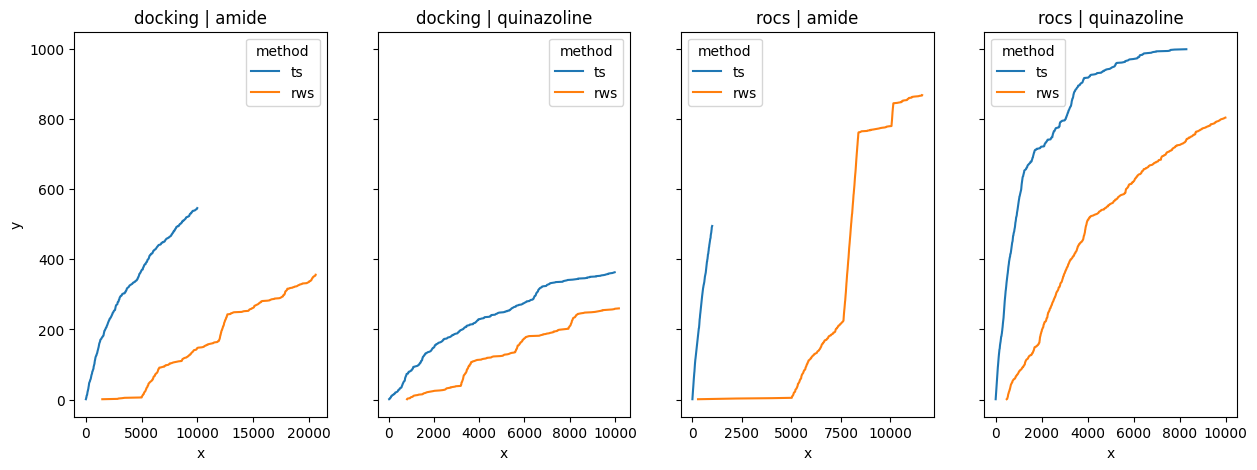

In [6]:
figure, axes = plt.subplots(1,4,sharey=True,figsize=(15,5))
df_list = []
for idx, (_, row) in enumerate(res_df.iterrows(),1):
    plot_df = pd.DataFrame({"x" : [x[0] for x in row.hit_order], "y" : [x[1] for x in row.hit_order]})
    plot_df['method'] = row.method
    df_list.append(plot_df)
    if idx % 2 == 0:
        ax = sns.lineplot(x="x",y="y",data=pd.concat(df_list),ax=axes[idx//2-1],hue="method")
        ax.set_title(f"{row.task} | {row.dataset}")
        df_list = []